# AFIB Detection Using 1D CNN on Cleaned ECG Dataset

This notebook trains a binary AFIB detector using the cleaned and balanced dataset generated by data_handling.ipynb.

Workflow:
1. Setup paths and load cleaned mapping
2. Verify data and prepare labels
3. Split dataset (train/val/test)
4. Compute global channel statistics
5. Define ECG dataset class
6. Create data loaders
7. Define and train 1D CNN model
8. Evaluate on test set


## 1. Imports


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All imports successful")


✓ All imports successful


## 2. Configuration & Path Setup


In [ ]:
# Hyperparameters
DOWNSAMPLE = 4  # Downsample factor (e.g., 2 = keep every 2nd sample)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (all relative to project root)
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CLEANED_ROOT = DATA_DIR / "cleaned_balanced_AFIB_SR"
CLEANED_WFDB_DIR = CLEANED_ROOT / "WFDBRecords"
MAPPING_CSV = CLEANED_ROOT / "file_mapping_cleaned_with_folds.csv"

# Model save path (main_2)
MODEL_DIR = PROJECT_ROOT / "models_2"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "ecg_1dcnn_afib_balanced.pth"

print(f"Device: {DEVICE}")
print(f"MAPPING_CSV: {MAPPING_CSV}")
print(f"MODEL_PATH: {MODEL_PATH}")
print("\n✓ Configuration complete")


Device: cuda
MAPPING_CSV: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\data\cleaned_balanced_AFIB_SR\file_mapping_cleaned.csv
MODEL_PATH: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\models_2\ecg_1dcnn_afib_balanced.pth

✓ Configuration complete


## 3. Load Cleaned Mapping & Verify Data


In [ ]:
# Load the cleaned mapping
cleaned_mapping = pd.read_csv(MAPPING_CSV)

print(f"Loaded {len(cleaned_mapping):,} records from {MAPPING_CSV.name}")
print(f"\nColumns: {list(cleaned_mapping.columns)}")

# Verify required columns exist
required_cols = ['record_id', 'ecg_path', '_AFIB', '_SR', 'fold']
missing_cols = [col for col in required_cols if col not in cleaned_mapping.columns]
assert not missing_cols, f"Missing required columns: {missing_cols}"
print(f"✓ All required columns present: {required_cols}")

# Basic statistics
print(f"\n--- Dataset Statistics ---")
print(f"Total records: {len(cleaned_mapping):,}")
print(f"AFIB records (_AFIB=1): {cleaned_mapping['_AFIB'].sum():,}")
print(f"Non-AFIB records (_AFIB=0): {(cleaned_mapping['_AFIB'] == 0).sum():,}")
print(f"SR records (_SR=1): {cleaned_mapping['_SR'].sum():,}")
print(f"Non-SR records (_SR=0): {(cleaned_mapping['_SR'] == 0).sum():,}")

# Display sample rows
print("\nSample rows:")
cleaned_mapping.head()


Loaded 3,555 records from file_mapping_cleaned.csv

Columns: ['record_id', 'ecg_path', '_AFIB', '_SR']
✓ All required columns present: ['record_id', 'ecg_path', '_AFIB', '_SR']

--- Dataset Statistics ---
Total records: 3,555
AFIB records (_AFIB=1): 1,780
Non-AFIB records (_AFIB=0): 1,775
SR records (_SR=1): 1,775
Non-SR records (_SR=0): 1,780

Sample rows:


,record_id,ecg_path,_AFIB,_SR
0,JS36340,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
1,JS04305,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,1,0
2,JS11050,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
3,JS23632,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
4,JS41351,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1


## 4. Prepare Labels for Binary AFIB Detection


In [4]:
# Use _AFIB as the primary target column
target_col = "_AFIB"

# Ensure target is strictly 0/1
cleaned_mapping[target_col] = pd.to_numeric(cleaned_mapping[target_col], errors='coerce').fillna(0)
cleaned_mapping[target_col] = (cleaned_mapping[target_col] > 0).astype(int)

print(f"Target column: {target_col}")
print("Target distribution:")
print(cleaned_mapping[target_col].value_counts().sort_index())
print("\n✓ Labels prepared for binary AFIB detection")


Target column: _AFIB
Target distribution:
_AFIB
0    1775
1    1780
Name: count, dtype: int64

✓ Labels prepared for binary AFIB detection


## 5. Split Dataset (Train/Val/Test)


In [ ]:
# Split dataset using precomputed patient-level folds (no leakage)
all_folds = sorted(cleaned_mapping['fold'].unique())
test_folds = [0, 1]  # outer test folds (~40% here because 2/5); adjust as needed
train_folds = [f for f in all_folds if f not in test_folds]
val_fold = train_folds[-1]  # use the last training fold for validation
train_only_folds = [f for f in train_folds if f != val_fold]

train_mask = cleaned_mapping['fold'].isin(train_only_folds)
val_mask = cleaned_mapping['fold'] == val_fold
test_mask = cleaned_mapping['fold'].isin(test_folds)

idx_train = cleaned_mapping.index[train_mask].to_numpy()
idx_val = cleaned_mapping.index[val_mask].to_numpy()
idx_test = cleaned_mapping.index[test_mask].to_numpy()

y_train = cleaned_mapping.loc[idx_train, target_col].to_numpy()
y_val = cleaned_mapping.loc[idx_val, target_col].to_numpy()
y_test = cleaned_mapping.loc[idx_test, target_col].to_numpy()

print("--- Dataset Splits (by fold) ---")
print(f"All folds: {all_folds}")
print(f"Train folds: {train_only_folds}")
print(f"Val fold: {val_fold}")
print(f"Test folds: {test_folds}")
print(f"Train: {len(idx_train):,} samples (AFIB: {y_train.sum():,}, Non-AFIB: {(y_train == 0).sum():,})")
print(f"Val:   {len(idx_val):,} samples (AFIB: {y_val.sum():,}, Non-AFIB: {(y_val == 0).sum():,})")
print(f"Test:  {len(idx_test):,} samples (AFIB: {y_test.sum():,}, Non-AFIB: {(y_test == 0).sum():,})")
print("\n✓ Dataset split complete (fold-based)")


--- Dataset Splits ---
Train: 2,844 samples (AFIB: 1,424, Non-AFIB: 1,420)
Val:   355 samples (AFIB: 178, Non-AFIB: 177)
Test:  356 samples (AFIB: 178, Non-AFIB: 178)

✓ Dataset split complete


## 6. Compute Global Channel Statistics


In [6]:
def compute_channel_stats(mapping, indices, downsample=None):
    """
    Compute global per-channel mean and std from a subset of training data.
    Stacks up to 512 random samples to estimate statistics.
    """
    if len(indices) > 512:
        sample_indices = np.random.choice(indices, size=512, replace=False)
    else:
        sample_indices = indices

    data_list = []

    for idx in sample_indices:
        row = mapping.iloc[int(idx)]
        npy_file = Path(row["ecg_path"])
        if not npy_file.exists():
            continue
        try:
            data = np.load(npy_file)
            # Ensure 2D array and shape (12, L)
            if data.ndim != 2:
                continue
            if data.shape[0] > data.shape[1]:
                data = data.T
            if data.shape[0] != 12:
                continue
            if downsample is not None and downsample > 1:
                data = data[:, ::downsample]
            data_list.append(data)
        except Exception:
            continue

    if not data_list:
        raise ValueError("No valid data loaded for computing statistics")

    # Align lengths to stack
    min_len = min(arr.shape[1] for arr in data_list)
    data_list = [arr[:, :min_len] for arr in data_list]
    stack = np.stack(data_list, axis=0)  # (N, 12, T)

    mean = stack.mean(axis=(0, 2)).astype(np.float32)
    std = (stack.std(axis=(0, 2)) + 1e-6).astype(np.float32)
    return mean, std

print("✓ Function defined: compute_channel_stats")


✓ Function defined: compute_channel_stats


In [7]:
# Compute global statistics from training set
print("Computing global channel statistics from training data...")
global_mean, global_std = compute_channel_stats(
    cleaned_mapping,
    idx_train,
    downsample=DOWNSAMPLE,
)

print(f"\nGlobal mean (per channel): {global_mean}")
print(f"Global std (per channel):  {global_std}")
print("\n✓ Channel statistics computed")


Computing global channel statistics from training data...

Global mean (per channel): [ 0.00087996  0.00407988  0.00319806 -0.00129608 -0.00234096  0.00245678
 -0.000341    0.00010127  0.00099349  0.00216968  0.00157251 -0.00544625]
Global std (per channel):  [0.13070686 0.15862711 0.13167788 0.12957436 0.10451327 0.13031137
 0.21526927 0.34992763 0.37169304 0.3652055  0.3307482  0.3247074 ]

✓ Channel statistics computed


## 7. Define ECG Dataset Class


In [8]:
class ECGDataset(Dataset):
    """PyTorch Dataset for ECG data that loads from .npy files."""
    def __init__(self, mapping, indices, downsample=None, target_col="_AFIB",
                 channel_mean=None, channel_std=None):
        self.mapping = mapping.iloc[indices].reset_index(drop=True)
        self.downsample = downsample
        self.target_col = target_col
        self.channel_mean = channel_mean if channel_mean is not None else np.zeros(12, dtype=np.float32)
        self.channel_std = channel_std if channel_std is not None else np.ones(12, dtype=np.float32)

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        row = self.mapping.iloc[idx]
        record_id = str(row["record_id"])
        # Resolve path robustly: support relative paths stored in CSV
        npy_file = Path(row["ecg_path"])
        if not npy_file.is_absolute():
            npy_file = (PROJECT_ROOT / npy_file).resolve()
        try:
            data = np.load(npy_file)
            # Ensure 2D array and shape (12, L)
            if data.ndim != 2:
                raise ValueError(f"Expected 2D array, got shape {data.shape}")
            if data.shape[0] > data.shape[1]:
                data = data.T
            if data.shape[0] != 12:
                raise ValueError(f"Expected 12 channels, got {data.shape[0]}")
            if self.downsample is not None and self.downsample > 1:
                data = data[:, ::self.downsample]
            # Normalize
            data = (data - self.channel_mean[:, None]) / self.channel_std[:, None]
        except Exception as e:
            print(f"Error loading {record_id}: {e}")
            # Fallback dummy tensor (kept simple)
            data = np.zeros((12, 2500), dtype=np.float32)
        try:
            tval = float(row[self.target_col])
            label = 1.0 if tval > 0 else 0.0
        except Exception:
            label = 0.0
        data_tensor = torch.from_numpy(data.astype(np.float32))
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return data_tensor, label_tensor

print("✓ ECGDataset class defined")


✓ ECGDataset class defined


## 8. Create DataLoaders


In [9]:
# Create datasets
train_ds = ECGDataset(cleaned_mapping, idx_train, downsample=DOWNSAMPLE, target_col="_AFIB",
                       channel_mean=global_mean, channel_std=global_std)
val_ds = ECGDataset(cleaned_mapping, idx_val, downsample=DOWNSAMPLE, target_col="_AFIB",
                     channel_mean=global_mean, channel_std=global_std)
test_ds = ECGDataset(cleaned_mapping, idx_test, downsample=DOWNSAMPLE, target_col="_AFIB",
                      channel_mean=global_mean, channel_std=global_std)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader:   {len(val_loader)} batches")
print(f"Test loader:  {len(test_loader)} batches")
print("\n✓ DataLoaders created")


Train loader: 89 batches
Val loader:   12 batches
Test loader:  12 batches

✓ DataLoaders created


## 9. Define 1D CNN Model


In [10]:
class ECG1DCNN(nn.Module):
    def __init__(self, in_channels=12, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = ECG1DCNN(in_channels=12, num_classes=1).to(DEVICE)
print(f"Model architecture:\n{model}")
print(f"\n✓ Model initialized on {DEVICE}")


Model architecture:
ECG1DCNN(
  (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

✓ Model initialized on cuda


## 10. Training Setup


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Loss function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print("\n✓ Training setup complete")


Loss function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.001)

✓ Training setup complete


## 11. Training Loop


In [12]:
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}
best_val_auc = 0.0

print(f"Starting training for {NUM_EPOCHS} epochs...\n")
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / max(1, len(train_loader))

    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data).squeeze()
            loss = criterion(output, target)
            val_loss += loss.item()
            probs = torch.sigmoid(output).cpu().numpy()
            all_preds.extend(probs)
            all_targets.extend(target.cpu().numpy())
    avg_val_loss = val_loss / max(1, len(val_loader))
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    val_auc = roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else 0.5
    val_acc = accuracy_score(all_targets, (all_preds > 0.5).astype(int))
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  → Best model saved (AUC: {val_auc:.4f})")

print(f"\n✓ Training complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")


Starting training for 30 epochs...

Epoch [1/30] Train Loss: 0.3613 | Val Loss: 0.1606 | Val AUC: 0.9866 | Val Acc: 0.9408
  → Best model saved (AUC: 0.9866)
Epoch [2/30] Train Loss: 0.1418 | Val Loss: 0.2873 | Val AUC: 0.9936 | Val Acc: 0.8732
  → Best model saved (AUC: 0.9936)
Epoch [3/30] Train Loss: 0.1039 | Val Loss: 0.0942 | Val AUC: 0.9937 | Val Acc: 0.9803
  → Best model saved (AUC: 0.9937)
Epoch [4/30] Train Loss: 0.0732 | Val Loss: 0.0972 | Val AUC: 0.9902 | Val Acc: 0.9859
Epoch [5/30] Train Loss: 0.0639 | Val Loss: 0.1750 | Val AUC: 0.9904 | Val Acc: 0.9662
Epoch [6/30] Train Loss: 0.0614 | Val Loss: 0.0617 | Val AUC: 0.9954 | Val Acc: 0.9803
  → Best model saved (AUC: 0.9954)
Epoch [7/30] Train Loss: 0.0525 | Val Loss: 0.0815 | Val AUC: 0.9916 | Val Acc: 0.9803
Epoch [8/30] Train Loss: 0.0322 | Val Loss: 0.0758 | Val AUC: 0.9913 | Val Acc: 0.9831
Epoch [9/30] Train Loss: 0.0358 | Val Loss: 0.0486 | Val AUC: 0.9981 | Val Acc: 0.9859
  → Best model saved (AUC: 0.9981)
Epoch 

## 12. Plot Training History


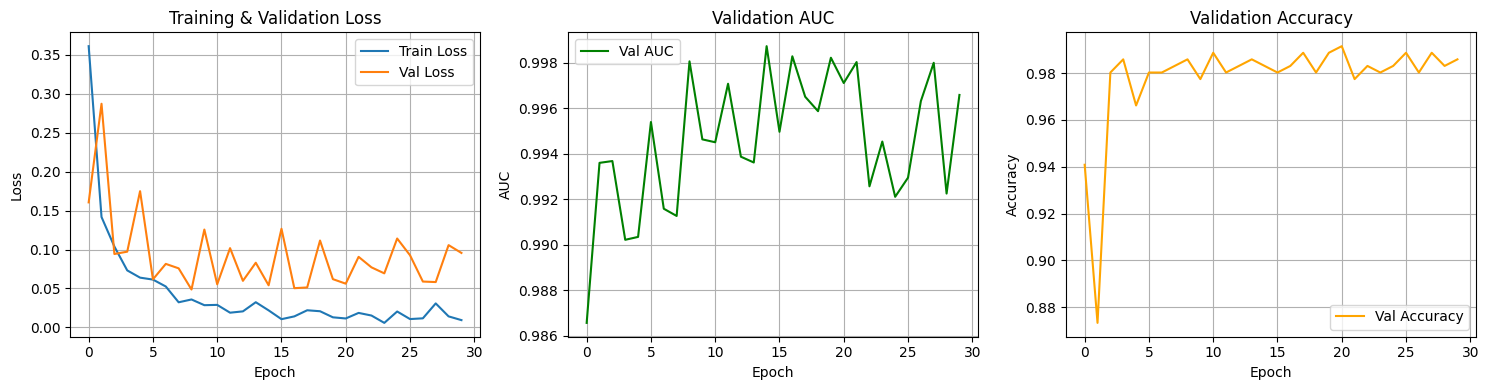

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend(); axes[0].grid(True)
axes[1].plot(history['val_auc'], label='Val AUC', color='green')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('AUC'); axes[1].set_title('Validation AUC')
axes[1].legend(); axes[1].grid(True)
axes[2].plot(history['val_acc'], label='Val Accuracy', color='orange')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Accuracy'); axes[2].set_title('Validation Accuracy')
axes[2].legend(); axes[2].grid(True)
plt.tight_layout(); plt.show()


## 13. Load Best Model & Evaluate on Test Set


In [14]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print(f"Loaded best model from {MODEL_PATH}")
print("\nEvaluating on test set...\n")

test_loss = 0.0
all_test_preds, all_test_targets = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data).squeeze()
        loss = criterion(output, target)
        test_loss += loss.item()
        probs = torch.sigmoid(output).cpu().numpy()
        all_test_preds.extend(probs)
        all_test_targets.extend(target.cpu().numpy())
avg_test_loss = test_loss / max(1, len(test_loader))
all_test_preds = np.array(all_test_preds)
all_test_targets = np.array(all_test_targets)

test_auc = roc_auc_score(all_test_targets, all_test_preds) if len(np.unique(all_test_targets)) > 1 else 0.5
test_pred_labels = (all_test_preds > 0.5).astype(int)
test_acc = accuracy_score(all_test_targets, test_pred_labels)
conf_matrix = confusion_matrix(all_test_targets, test_pred_labels)

print("--- Test Set Results ---")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(all_test_targets, test_pred_labels, target_names=['Non-AFIB', 'AFIB']))


C:\Users\Adrian\AppData\Local\Temp\ipykernel_15724\1384613139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Loaded best model from c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\models_2\ecg_1dcnn_afib_balanced.pth

Evaluating on test set...

--- Test Set Results ---
Test Loss: 0.0369
Test AUC:  0.9992
Test Acc:  0.9916

Confusion Matrix:
[[175   3]
 [  0 178]]

Classification Report:
              precision    recall  f1-score   support

    Non-AFIB       1.00      0.98      0.99       178
        AFIB       0.98      1.00      0.99       178

    accuracy                           0.99       356
   macro avg       0.99      0.99      0.99       356
weighted avg       0.99      0.99      0.99       356



## 14. Visualize Confusion Matrix


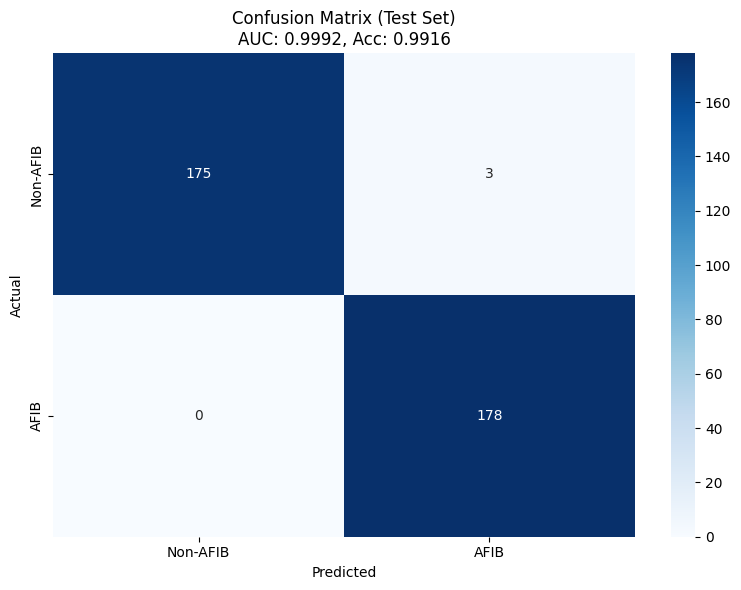


✓ AFIB detection pipeline complete!


In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-AFIB', 'AFIB'],
            yticklabels=['Non-AFIB', 'AFIB'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Set)\nAUC: {test_auc:.4f}, Acc: {test_acc:.4f}')
plt.tight_layout()
plt.show()

print("\n============================================================")
print("✓ AFIB detection pipeline complete!")
print("============================================================")


## 15. ROC Curve (Receiver Operating Characteristic)

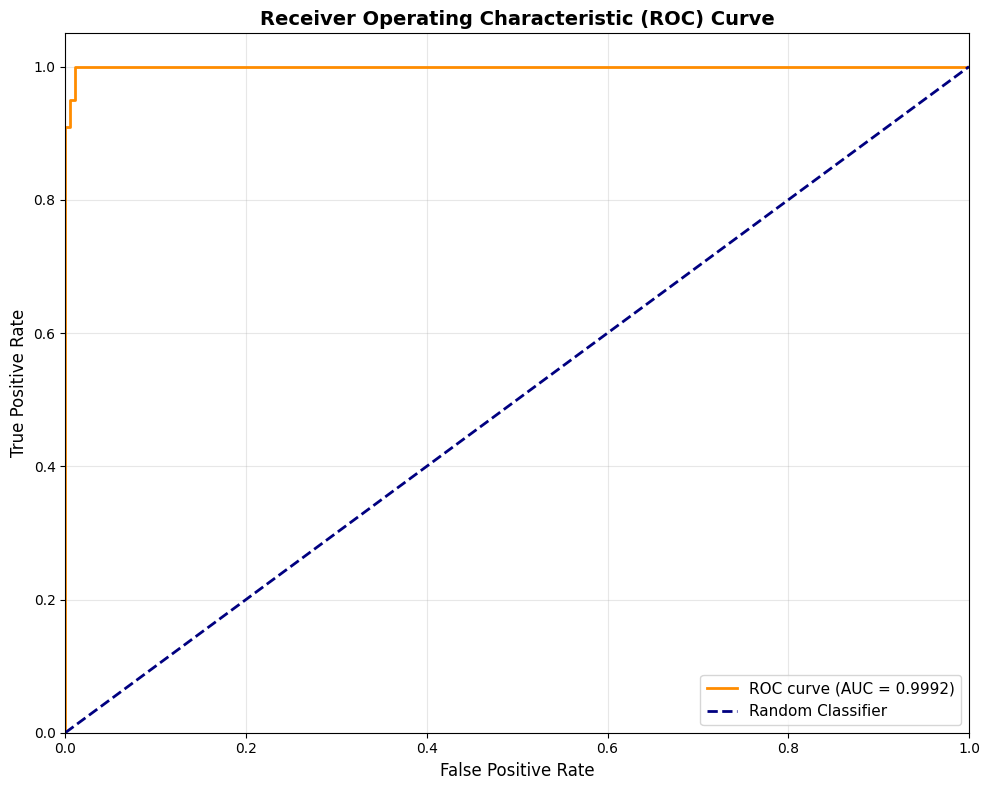

ROC-AUC Score: 0.9992


In [16]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_test_targets, all_test_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

## 16. DET Curve (Detection Error Tradeoff)

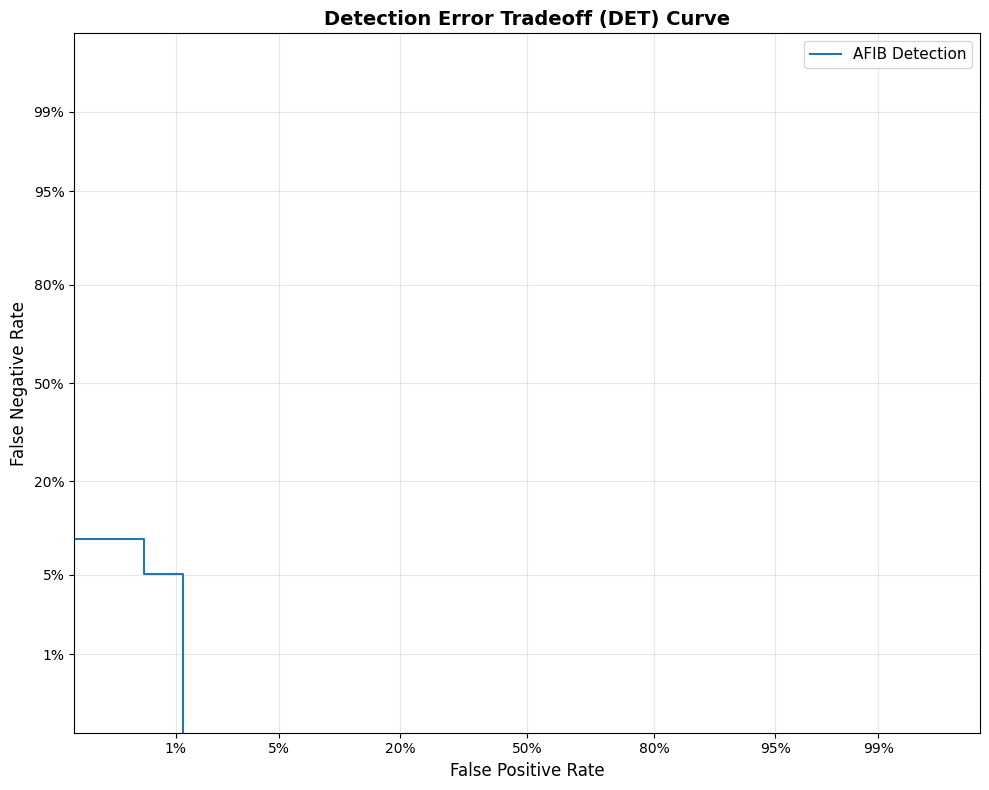

DET Curve: Lower values indicate better performance
The curve shows the tradeoff between false positives and false negatives


In [17]:
from sklearn.metrics import DetCurveDisplay

# Create and plot DET curve
fig, ax = plt.subplots(figsize=(10, 8))
DetCurveDisplay.from_predictions(all_test_targets, all_test_preds, ax=ax, name='AFIB Detection')

ax.set_title('Detection Error Tradeoff (DET) Curve', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('False Negative Rate', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("DET Curve: Lower values indicate better performance")
print(f"The curve shows the tradeoff between false positives and false negatives")

# 17. Metrics

In [18]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, roc_auc_score
)

# Choose source: prefer test-set outputs, fallback to validation
if 'all_test_targets' in globals() and 'all_test_preds' in globals():
    y_true = np.array(all_test_targets)
    y_prob = np.array(all_test_preds)
elif 'all_targets' in globals() and 'all_preds' in globals():
    y_true = np.array(all_targets)
    y_prob = np.array(all_preds)
else:
    print("No predictions found. Run the evaluation cell (Section 13) or the training loop first.")
    y_true = np.array([])
    y_prob = np.array([])

if y_true.size > 0 and y_prob.size > 0:
    # Binary predictions at 0.5 threshold
    y_pred = (y_prob > 0.5).astype(int)

    # Core metrics
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Specificity (True Negative Rate) with stable 2x2 matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    # ROC-AUC using probabilities
    roc_auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.5

    print(f"Acc:  {acc:.3f}")
    print(f"F1:   {f1:.3f}")
    print(f"Pre:  {pre:.3f}")
    print(f"Rec:  {rec:.3f}")
    print(f"Spec: {spec:.3f}")
    print(f"MCC:  {mcc:.3f}")
    print(f"AUC:  {roc_auc:.3f}")
else:
    print("Metrics not computed because prediction arrays are empty.")

Acc:  0.992
F1:   0.992
Pre:  0.983
Rec:  1.000
Spec: 0.983
MCC:  0.983
AUC:  0.999


In [19]:

# Save results to results folder
from datetime import datetime

# Create results directory if it doesn't exist
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Calculate sample rate (original 500 Hz downsampled by factor DOWNSAMPLE)
original_sample_rate = 500  # Hz
sample_rate = original_sample_rate / DOWNSAMPLE  # Hz

# Generate results file
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = "1D-CNN"
results_filename = RESULTS_DIR / f"results_{model_name}_{timestamp}.txt"

# Format results text
results_text = f"""
================================================================================
AFIB Detection Model Results
================================================================================
Model Name:        {model_name}
Sample Rate:       {sample_rate:.1f} Hz (Original: {original_sample_rate} Hz, Downsample: {DOWNSAMPLE}x)
Batch Size:        {BATCH_SIZE}
Learning Rate:     {LEARNING_RATE}
Num Epochs:        {NUM_EPOCHS}
Device:            {DEVICE}
Timestamp:         {timestamp}

================================================================================
Test Set Metrics
================================================================================
Accuracy (Acc):    {acc:.4f}
F1-Score (F1):     {f1:.4f}
Precision (Pre):   {pre:.4f}
Recall (Rec):      {rec:.4f}
Specificity (Spec):{spec:.4f}
Matthews Corr Coef:{mcc:.4f}
ROC-AUC (AUC):     {roc_auc:.4f}

Test Loss:         {avg_test_loss:.4f}

================================================================================
Confusion Matrix
================================================================================
                  Predicted
               Non-AFIB  AFIB
Actual Non-AFIB    {TN:>4d}    {FP:>4d}
       AFIB        {FN:>4d}    {TP:>4d}

TP (True Positive):   {TP}
TN (True Negative):   {TN}
FP (False Positive):  {FP}
FN (False Negative):  {FN}

================================================================================
"""

# Write to file
with open(results_filename, 'w') as f:
    f.write(results_text)

print(f"✓ Results saved to: {results_filename}")
print(results_text)


✓ Results saved to: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\results\results_1D-CNN_2025-12-16_14-15-11.txt

AFIB Detection Model Results
Model Name:        1D-CNN
Sample Rate:       125.0 Hz (Original: 500 Hz, Downsample: 4x)
Batch Size:        32
Learning Rate:     0.001
Num Epochs:        30
Device:            cuda
Timestamp:         2025-12-16_14-15-11

Test Set Metrics
Accuracy (Acc):    0.9916
F1-Score (F1):     0.9916
Precision (Pre):   0.9834
Recall (Rec):      1.0000
Specificity (Spec):0.9831
Matthews Corr Coef:0.9833
ROC-AUC (AUC):     0.9992

Test Loss:         0.0369

Confusion Matrix
                  Predicted
               Non-AFIB  AFIB
Actual Non-AFIB     175       3
       AFIB           0     178

TP (True Positive):   178
TN (True Negative):   175
FP (False Positive):  3
FN (False Negative):  0


